In [1]:
import pickle
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm


In [2]:
def load_episode_data(path: str) -> dict:
    """Load the data from one episode recording .pkl file."""
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data


def load_eval_data(eval_dir: str, progress_bar: bool = False) -> list[dict]:
    """
    Load all episode pickle files from an evaluation firectory. Expects `problem_xxx`
    directories, each of which has a `recorded_episdoe_1.pkl file in it.
    """
    paths = sorted(glob(f"{eval_dir}/problem_*/recorded_episode_1.pkl"))
    if progress_bar:
        paths = tqdm(paths)
    data = [load_episode_data(p) for p in paths]
    return data


In [3]:
def get_maes(episode: dict) -> list:
    """Get sequence of step-wise MAEs from episode data in `episode`."""
    beams = [obs["beam"] for obs in episode["observations"]]
    target = episode["observations"][0]["target"]
    maes = np.mean(np.abs(np.array(beams) - np.array(target)), axis=1).tolist()

    return maes


In [4]:
def compute_min_maes(maes: list) -> list:
    """From the sequence of MAEs compute the sequence of lowest already seen MAEs."""
    min_maes = [min(maes[: i + 1]) for i in range(len(maes))]
    return min_maes


In [13]:
def get_steps_to_treshold(episode: list, threshold: float = 20e-6) -> int:
    """Find the number of steps until the maes in `episdoe` drop below `threshold`."""
    episode = np.array(episode)
    arg_lower = np.argwhere(episode < threshold).squeeze()
    return arg_lower[0] if len(arg_lower) > 0 else len(episode)


In [31]:
def find_convergence(episode: list, threshold: float = 20e-6) -> int:
    df = pd.DataFrame({"min_mae": episode})
    df["mae_diff"] = df["min_mae"].diff()
    df["abs_mae_diff"] = df["mae_diff"].abs()

    convergence_step = df.index.max()
    for i in df.index:
        x = all(df.loc[i:, "abs_mae_diff"] < threshold)
        if x:
            convergence_step = i
            break

    return convergence_step


In [36]:
def plot_steps_to_threshold_box(data: list[dict], threshold=20e-6) -> None:
    """
    Box plot number of steps until best seen MAE drops below (resolution) `threshold`.
    """
    maes = [get_maes(episode) for episode in data]
    min_maes = [compute_min_maes(episode) for episode in maes]
    steps = [get_steps_to_treshold(episode, threshold) for episode in min_maes]

    plt.figure(figsize=(10, 5))
    plt.title(f"Steps to MAE below {threshold}")
    sns.boxplot(x=steps)
    plt.grid(ls="--")
    plt.gca().set_axisbelow(True)
    plt.tight_layout()
    plt.show()


def plot_steps_to_convergence_box(data: list[dict], threshold=20e-6) -> None:
    """
    Box plot number of steps until best seen MAE no longer improves by more than
    `threshold`.
    """
    maes = [get_maes(episode) for episode in data]
    min_maes = [compute_min_maes(episode) for episode in maes]
    steps = [find_convergence(episode, threshold) for episode in min_maes]

    plt.figure(figsize=(10, 5))
    plt.title(f"Steps to convergence (limit = {threshold})")
    sns.boxplot(x=steps)
    plt.grid(ls="--")
    plt.gca().set_axisbelow(True)
    plt.tight_layout()
    plt.show()


def plot_mae_over_time(data: list[dict]) -> None:
    """Plot mean MAE of over episodes over time."""
    maes = [get_maes(episode) for episode in data]

    ds = [
        {"mae": episode, "step": range(len(episode)), "problem": i}
        for i, episode in enumerate(maes)
    ]
    df = pd.concat(pd.DataFrame(d) for d in ds)

    plt.figure(figsize=(10, 6))
    sns.lineplot(x="step", y="mae", data=df)
    plt.title("Mean MAE Over Time")
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.grid(ls="--")
    plt.gca().set_axisbelow(True)
    plt.show()


def plot_best_mae_over_time(data: list[dict]) -> None:
    """Plot mean best seen MAE over all episdoes over time."""
    """Plot mean MAE of over episodes over time."""
    maes = [get_maes(episode) for episode in data]
    min_maes = [compute_min_maes(episode) for episode in maes]

    ds = [
        {"mae": episode, "step": range(len(episode)), "problem": i}
        for i, episode in enumerate(min_maes)
    ]
    df = pd.concat(pd.DataFrame(d) for d in ds)

    plt.figure(figsize=(10, 6))
    sns.lineplot(x="step", y="mae", data=df)
    plt.title("Mean Best MAE Over Time")
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.grid(ls="--")
    plt.gca().set_axisbelow(True)
    plt.show()


def plot_final_mae_box(data: list[dict]) -> None:
    """
    Box plot of the final MAE that the algorithm stopped at (without returning to best
    seen.
    """
    maes = [get_maes(episode) for episode in data]
    final_maes = [episode[:-1] for episode in maes]

    plt.figure(figsize=(10, 5))
    plt.title("Final MAEs")
    sns.boxplot(x=final_maes)
    plt.xscale("log")
    plt.grid(ls="--")
    plt.gca().set_axisbelow(True)
    plt.tight_layout()
    plt.show()


def plot_best_mae_box(data: list[dict]) -> None:
    """Box plot of best MAEs seen until the very end of the episodes."""
    maes = [get_maes(episode) for episode in data]
    final_maes = [min(episode) for episode in maes]

    plt.figure(figsize=(10, 5))
    plt.title("Best MAEs")
    sns.boxplot(x=final_maes)
    plt.xscale("log")
    plt.grid(ls="--")
    plt.gca().set_axisbelow(True)
    plt.tight_layout()
    plt.show()


In [37]:
data = load_eval_data("bo_rl_opponent_evaluation")


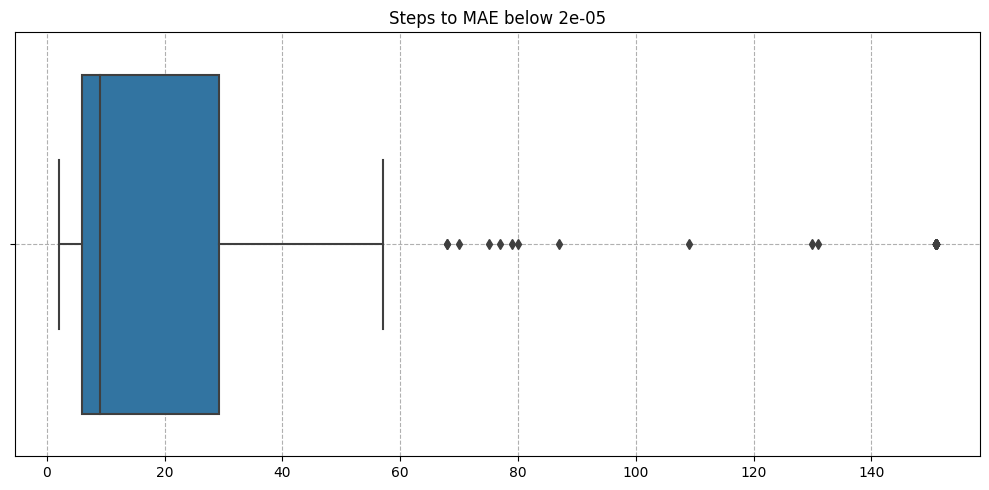

In [38]:
plot_steps_to_threshold_box(data)


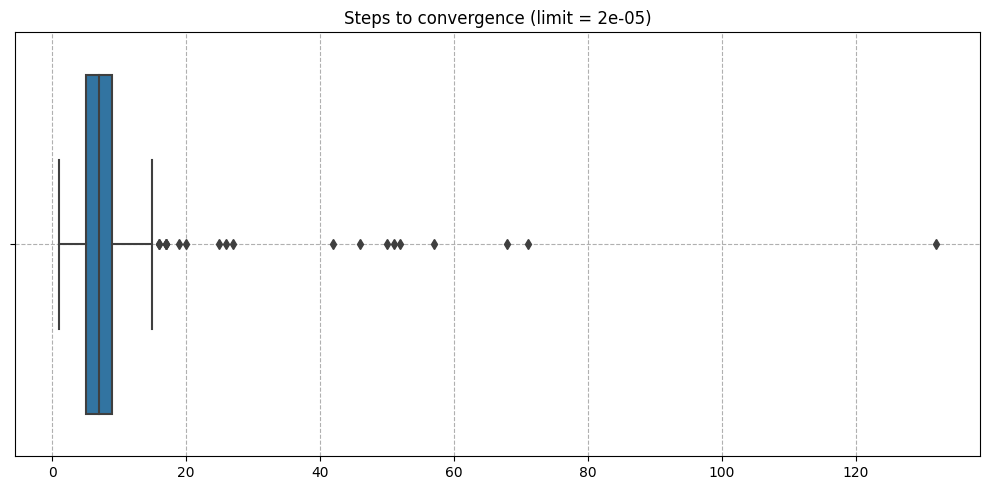

In [39]:
plot_steps_to_convergence_box(data)


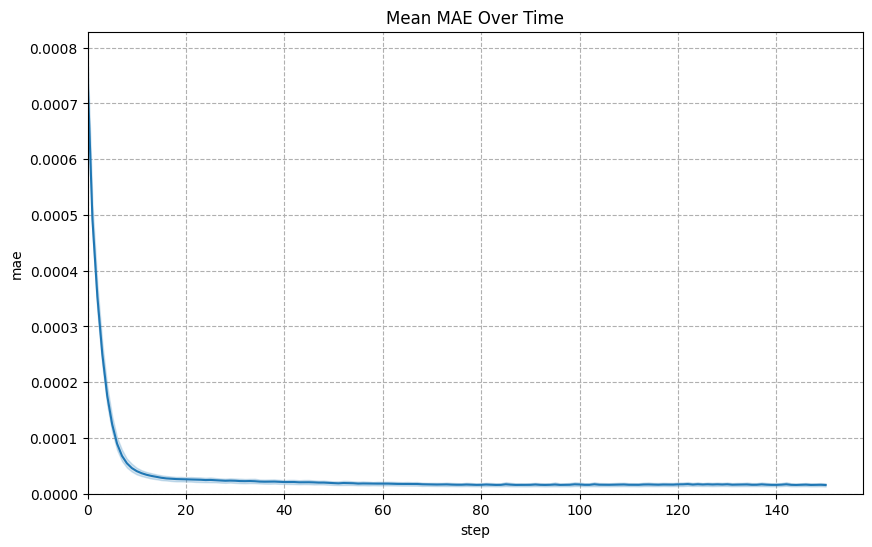

In [40]:
plot_mae_over_time(data)


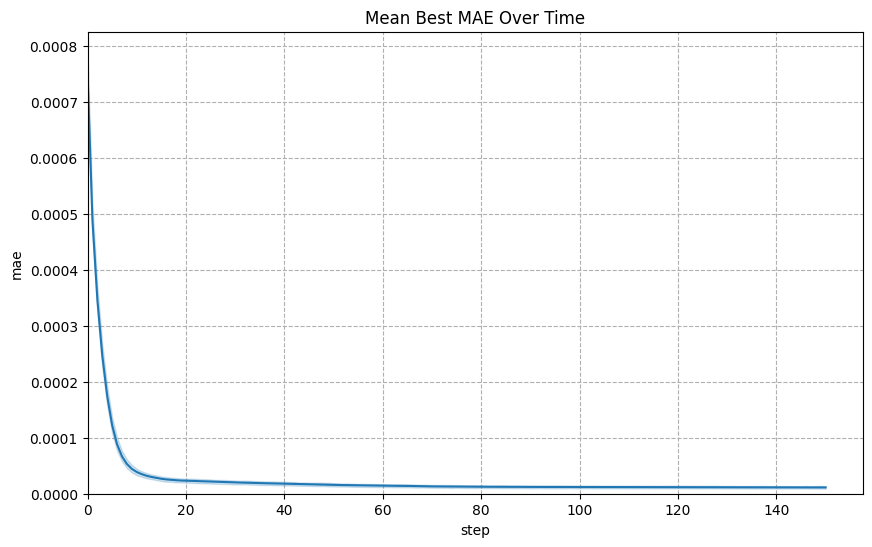

In [41]:
plot_best_mae_over_time(data)


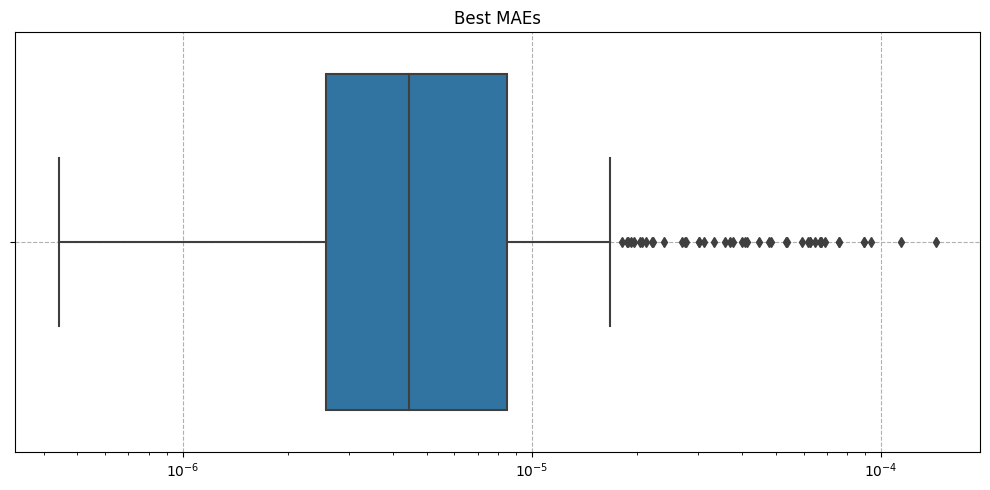

In [42]:
plot_best_mae_box(data)
